In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
import numpy as np
from sklearn.cluster import KMeans

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
import cv2
from sklearn.metrics import accuracy_score
import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall ,F1Score


import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [3]:
data_path = r"Combined_images"
image_list = []
file_names = []

# Iterate over each file in the specified directory
for filename in os.listdir(data_path):
    if filename.endswith(('.jpg', '.png', '.tif', '.JPG')):
        file_path = os.path.join(data_path, filename)
        img = cv2.imread(file_path)
        # Append the image and its filename to the lists
        image_list.append(img)
        file_names.append(filename)

In [4]:
# Function to extract the number from the image filename
def extract_number_from_filename(filename):
    # Assuming the number is after 'combined_' and before the first '.'
    return filename.split('_')[1].split('.')[0]

In [5]:
clean_file_names = []
for name in file_names:
    clean_file_names.append(extract_number_from_filename(name))

In [6]:
# Sample data (replace these with your actual data)
images = image_list
image_names = clean_file_names

# Function to read the CSV and create a dictionary of image names to labels
def read_csv_to_dict(csv_file):
    df = pd.read_csv(csv_file)

    # Extract image names and labels
    image_names = df.iloc[:, 0].values
    labels = df.iloc[:, -1].values

    # Create a list of image-label pairs
    image_label_array = np.array([[name, label] for name, label in zip(image_names, labels)])
    
    # Convert the NumPy array to a dictionary
    image_label_dict = {row[0]: row[1] for row in image_label_array}
    return image_label_dict


# Function to create the list of images and their corresponding labels
def create_image_label_list(images, image_names, image_label_dict):
    image_label_list = []
    for image, name in zip(images, image_names):
        if name in image_label_dict:
            label = image_label_dict[name]
            image_label_list.append([name,image, label])
    return image_label_list

# Main execution
csv_file_path = 'image_labels.csv'  # Replace with your actual CSV file path
image_label_dict = read_csv_to_dict(csv_file_path)
image_label_list = create_image_label_list(images, image_names, image_label_dict)

# Output the result
# for item in image_label_list:
#     print(item)

In [6]:
len(image_label_list)

625

In [7]:
df = pd.read_csv('image_labels.csv', names=['image_num','b','c','label'])

In [8]:
df['label'].value_counts()

label
Misr                        251
al-Mansuriyah               223
m.                          104
al-Mahdiyah                  40
(al-Mansuriyah)              10
Filastin                      9
al-Mansuriyah?                8
uncertain                     5
(Atarablus)                   4
al-Qahirah al-Mahrusah        4
Sur                           3
Barqa                         3
Atarablus                     3
Makka                         2
Tabariyyah                    2
Zawilah                       2
(al-Qahirah al-Mahrusah)      1
Dimashq                       1
Madinat Rasul Allah?          1
no mint                       1
Name: count, dtype: int64

In [9]:
two_largest_list = []
for instance in image_label_list:
    if instance[2]=='Misr' or instance[2]=='al-Mansuriyah'or instance[2]=='(al-Mansuriyah)':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        two_largest_list.append(instance)

In [10]:
len(two_largest_list)

452

In [11]:
# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

In [12]:
X = X/255.0
Y = np.array([0 if x == 'Misr' else 1 for x in Y])

In [13]:
X.shape

(452, 300, 600, 3)

In [14]:
def print_ratios_one_input(Y):
    # Assuming y_train_first is your training labels ndarray
    unique, counts = np.unique(Y, return_counts=True)

    # Combine the unique labels with their counts
    label_counts = dict(zip(unique, counts))

    print(label_counts)
    

In [15]:
def print_ratios_Two_inputs(Y_train,Y_val):
    # Assuming y_train_first is your training labels ndarray
    unique, counts = np.unique(Y_train, return_counts=True)

    # Combine the unique labels with their counts
    label_counts_train = dict(zip(unique, counts))

    # Print the count of each label
    # Assuming y_train_first is your training labels ndarray
    unique, counts = np.unique(Y_val, return_counts=True)

    # Combine the unique labels with their counts
    label_counts_test = dict(zip(unique, counts))
    print("train",label_counts_train)
    print("val",label_counts_test)

In [16]:
print_ratios_one_input(Y)


{0: 235, 1: 217}


In [17]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [18]:
print_ratios_Two_inputs(y_train_first,y_test)

train {0: 188, 1: 173}
val {0: 47, 1: 44}


In [19]:
y_test = to_categorical(y_test, num_classes=2)
# print(y_test)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

In [21]:
print_ratios_Two_inputs(y_train,y_val)

train {0: 150, 1: 138}
val {0: 38, 1: 35}


In [22]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
# print(y_train)
# print(y_val)

In [13]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

# Path to your images and the label dictionary
data_path = 'Combined_images'

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array) # VGG16 preprocessing includes normalization
    return img_array

# Search for image files and load images and labels
images = []
image_labels = []
for key, label in image_label_dict.items():
    found = False
    for root, _, files in os.walk(data_path):
        for file in files:
            if key in file and (label == 'Misr' or label == 'al-Mansuriyah'):
                file_path = os.path.join(root, file)
                img_array = load_and_preprocess_image(file_path)
                images.append(img_array)
                image_labels.append(label)
                found = True
                break
        if found:
            break

# Convert to numpy arrays
images = np.array(images)
image_labels = np.array(image_labels)

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(np.unique(image_labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
image_labels = np.array([label_to_index[label] for label in image_labels])

# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(images, image_labels, test_size=0.2, random_state=42, stratify=image_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(label_to_index))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(label_to_index))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(label_to_index))

In [14]:
# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers for transfer learning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_to_index), activation='softmax')(x)

# Combine base model and new top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (not trainable)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32
)

# Save the trained model
model.save('fine_tuned_vgg16.h5')


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5226 - loss: 17.9188 - val_accuracy: 0.7465 - val_loss: 1.7236
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7326 - loss: 5.2758 - val_accuracy: 0.9437 - val_loss: 0.9863
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.7797 - loss: 5.6576 - val_accuracy: 0.8732 - val_loss: 2.2685
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.8804 - loss: 2.5638 - val_accuracy: 0.9296 - val_loss: 0.9102
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.8722 - loss: 2.3675 - val_accuracy: 0.9155 - val_loss: 1.9579
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9017 - loss: 1.5500 - val_accuracy: 0.9577 - val_loss: 1.1525
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9133 - loss: 1.4283 - val_accuracy: 0.9296 - val_loss: 2.4573
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.9249 - loss: 2.0287 - val_accuracy: 0.9577 - val_loss: 1.6494
Epoch 9

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9849 - loss: 0.7221  
Test accuracy: 0.98


In [43]:
# plot the model architecture
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, show_shapes=True)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
You must install pydot (`pip install pydot`) for `plot_model` to work.


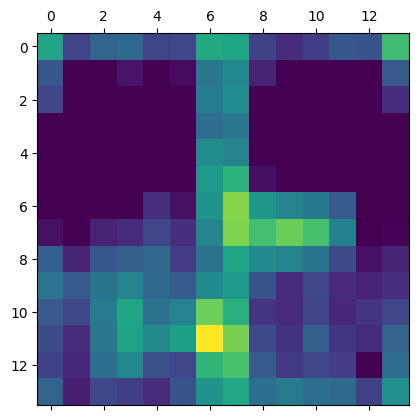

In [33]:
# Function to generate Grad-CAM for the fine-tuned model
def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    grads = tape.gradient(top_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

# Load and preprocess the image
img_path = 'Combined_images/combined_151152.1.jpg_151152.2.jpg'  # Replace with your image path
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, img_array)

# Display the heatmap
plt.matshow(heatmap)
plt.show()



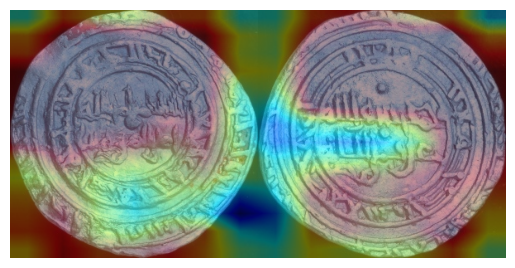

In [34]:
# show the gradcam on the image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()




In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 600, 3))

# Create a model to extract features
model = Model(inputs=base_model.input, outputs=base_model.output)

In [24]:
def extract_features(model, images):
    features = []
    for img in images:
        img = preprocess_input(img)  # Preprocess the image as required by VGG16
        img = np.expand_dims(img, axis=0)  # Add a batch dimension
        feature = model.predict(img)
        features.append(feature.flatten())  # Flatten the feature map
    return np.array(features)

X_features = extract_features(model, X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [25]:
# save the model to disk
import pickle
filename = 'features_model.sav'
pickle.dump(model, open(filename, 'wb'))

# save the features to disk
filename = 'features.sav'
pickle.dump(X_features, open(filename, 'wb'))


In [43]:
import pickle
# load the features from disk
X_features = pickle.load(open('features.sav', 'rb'))

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train_features, X_test_features, y_train, y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42, stratify=Y)

# Train a logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_features, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test_features)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9340659340659341


In [52]:
# Load your pre-trained VGG16 model
model = VGG16(weights='imagenet')



In [35]:
# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name='block5_conv3'):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        top_pred_index = tf.argmax(predictions[0])
        top_class_channel = predictions[:, top_pred_index]

    grads = tape.gradient(top_class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


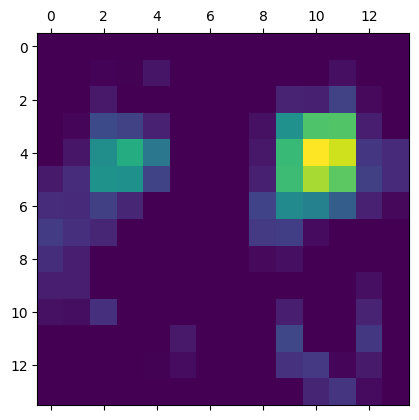

In [36]:

# Load and preprocess the image
img_path = 'Combined_images/combined_151119.1.jpg_151119.2.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Generate Grad-CAM heatmap
heatmap = generate_gradcam(model, img_array)

# Display the heatmap
plt.matshow(heatmap)
plt.show()

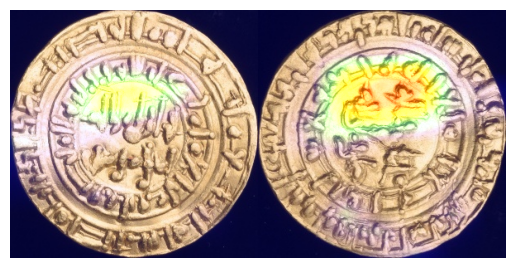

In [37]:

# Superimpose the heatmap on the original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# Convert the image to the appropriate depth
superimposed_img = cv2.convertScaleAbs(superimposed_img)

cv2.imwrite('gradcam_output.jpg', superimposed_img)

plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [59]:

model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

In [60]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 300, 600, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 150, 300, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 150, 300, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 75, 150, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 360000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      46,080,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,085,474 (175.80 MB)

 Trainable params: 46,085,474 (175.80 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [62]:
history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.4629 - loss: 20.9588 - val_accuracy: 0.5205 - val_loss: 0.7538
Epoch 2/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.5301 - loss: 1.2465 - val_accuracy: 0.5205 - val_loss: 0.7277
Epoch 3/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 695ms/step - accuracy: 0.5523 - loss: 0.6917 - val_accuracy: 0.4795 - val_loss: 0.6955
Epoch 4/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step - accuracy: 0.4485 - loss: 0.7101 - val_accuracy: 0.4795 - val_loss: 0.6907
Epoch 5/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 687ms/step - accuracy: 0.5295 - loss: 0.6950 - val_accuracy: 0.5205 - val_loss: 0.6930
Epoch 6/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step - accuracy: 0.5404 - loss: 0.7034 - val_accuracy: 0.5205 - val_loss: 0.6929
Epoch 7/18
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step - accuracy: 0.4828 - loss: 0.6985 - val_accuracy: 0.5205 - val_loss: 0.7036
Epoch 7: early stopping


In [27]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.3587842583656311 Accuracy: 0.8681318759918213


In [36]:
# Define the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(300, 600, 3), padding='same', name='conv2d_4'))
model.add(MaxPooling2D((2, 2), name='max_pooling2d_4'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv2d_5'))
model.add(MaxPooling2D((2, 2), name='max_pooling2d_5'))
model.add(Flatten(name='flatten_2'))
model.add(Dense(128, activation='relu', name='dense_4'))
model.add(Dropout(0.2, name='dropout_2'))
model.add(Dense(2, activation='softmax', name='dense_5'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=18, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the model
model.save('my_model.h5')

# Load the model
model = load_model('my_model.h5')

# Make a prediction to build the model layers
_ = model.predict(np.expand_dims(X_test[0], axis=0))

# Function to compute Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    return heatmap

# Function to display Grad-CAM
def display_gradcam(img, heatmap):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / np.max(overlay)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.show()

# Select an image from the test set
img = X_test[0]
img_array = np.expand_dims(img, axis=0)

# Get Grad-CAM heatmap for the last convolutional layer
layer_name = 'conv2d_5'  # Use the correct last conv layer name
heatmap = get_gradcam(model, img_array, layer_name)

# Display Grad-CAM
display_gradcam(img, heatmap)

Epoch 1/18


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(32,), output.shape=(32, 2)

In [79]:
three_largest_list = []
for instance in image_label_list:
    if instance[2]=='Misr' or instance[2]=='al-Mansuriyah' or instance[2]=='(al-Mansuriyah)' or instance[2]=='m.':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
            print(instance[2])
        three_largest_list.append(instance)

In [80]:
len(three_largest_list)

543

In [134]:
# Convert resized_image_list to numpy array
X = np.array([row[1] for row in three_largest_list])
Y = [row[2] for row in three_largest_list]

In [82]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [135]:
X = X/255.0
Y = np.array([0 if x == 'Misr' else 1 if x == 'al-Mansuriyah' else 2 for x in Y])

In [139]:
Y

In [140]:
print_ratios_one_input(Y)

{0: 235, 1: 217, 2: 91}


In [141]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42,stratify=Y)

In [142]:
print_ratios_Two_inputs(y_train,y_test)

train {0: 188, 1: 173, 2: 73}
val {0: 47, 1: 44, 2: 18}


In [144]:
y_test = to_categorical(y_test, num_classes=3)
print(y_test)

In [145]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42,stratify=y_train)

In [146]:
print_ratios_Two_inputs(y_train_2,y_val)

train {0: 150, 1: 138, 2: 59}
val {0: 38, 1: 35, 2: 14}


In [148]:
y_train_2 = to_categorical(y_train_2, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
print(y_train_2)
print(y_val)

In [29]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [113]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer for 3 classes
model.add(Dense(3, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 360000)            0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,verbose=1)

In [115]:
# Train the model
history = model.fit(
     X_train_2, y_train_2,
#     datagen.flow(X_train, y_train, batch_size=32),
    epochs=18,  # Increase the number of epochs to allow for more training
    validation_data=(X_val, y_val)
#     callbacks=[early_stopping]
)


Epoch 1/18
11/11 [==============================] - 14s 1s/step - loss: 26.1985 - accuracy: 0.4121 - val_loss: 3.0150 - val_accuracy: 0.1609
Epoch 2/18
11/11 [==============================] - 11s 1s/step - loss: 1.6203 - accuracy: 0.3948 - val_loss: 1.0177 - val_accuracy: 0.5287
Epoch 3/18
11/11 [==============================] - 11s 969ms/step - loss: 1.0555 - accuracy: 0.5418 - val_loss: 1.0411 - val_accuracy: 0.5747
Epoch 4/18
11/11 [==============================] - 11s 962ms/step - loss: 0.9670 - accuracy: 0.5965 - val_loss: 0.8285 - val_accuracy: 0.6897
Epoch 5/18
11/11 [==============================] - 10s 930ms/step - loss: 0.6530 - accuracy: 0.7493 - val_loss: 0.8456 - val_accuracy: 0.7011
Epoch 6/18
11/11 [==============================] - 10s 955ms/step - loss: 0.3538 - accuracy: 0.8934 - val_loss: 0.6479 - val_accuracy: 0.8046
Epoch 7/18
11/11 [==============================] - 10s 936ms/step - loss: 0.2011 - accuracy: 0.9481 - val_loss: 0.6626 - val_accuracy: 0.7586
Epoc

In [116]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.8091941475868225 Accuracy: 0.7431192398071289


    We want to improve our accuracy.
    I order to do that we will try to find why our model is having difficulties by checking how well it does between all types of coins in pairs
   

In [155]:
# make a list of m. and al-Mansuriyah

two_largest_list = []
for instance in image_label_list:
    if instance[2]=='m.' or instance[2]=='al-Mansuriyah'or instance[2]=='(al-Mansuriyah)':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        two_largest_list.append(instance)

In [157]:
len(two_largest_list)

308

In [160]:
# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

In [161]:
X = X/255.0
Y = np.array([0 if x == 'm.' else 1 for x in Y])

In [162]:
print_ratios_one_input(Y)

{0: 91, 1: 217}


In [171]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

In [172]:
print_ratios_Two_inputs(y_train_first,y_test)

train {0: 73, 1: 173}
val {0: 18, 1: 44}


In [174]:
y_test = to_categorical(y_test, num_classes=2)
print(y_test)

In [175]:
X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

In [176]:
print_ratios_Two_inputs(y_train,y_val)

train {0: 58, 1: 138}
val {0: 15, 1: 35}


In [178]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
print(y_train)
print(y_val)

In [185]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

In [186]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 360000)            0         
                                                                 
 dense_24 (Dense)            (None, 128)             

In [187]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [188]:
history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val)
#     callbacks=[early_stopping]
)

Epoch 1/18
7/7 [==============================] - 10s 1s/step - loss: 22.9564 - accuracy: 0.6224 - val_loss: 5.8904 - val_accuracy: 0.7000
Epoch 2/18
7/7 [==============================] - 8s 1s/step - loss: 3.6090 - accuracy: 0.6224 - val_loss: 1.5570 - val_accuracy: 0.7000
Epoch 3/18
7/7 [==============================] - 6s 919ms/step - loss: 0.9939 - accuracy: 0.6735 - val_loss: 0.7001 - val_accuracy: 0.4000
Epoch 4/18
7/7 [==============================] - 6s 914ms/step - loss: 0.6403 - accuracy: 0.7194 - val_loss: 0.6234 - val_accuracy: 0.7000
Epoch 5/18
7/7 [==============================] - 7s 933ms/step - loss: 0.5848 - accuracy: 0.7041 - val_loss: 0.6277 - val_accuracy: 0.7000
Epoch 6/18
7/7 [==============================] - 6s 840ms/step - loss: 0.5869 - accuracy: 0.7194 - val_loss: 0.6005 - val_accuracy: 0.6800
Epoch 7/18
7/7 [==============================] - 6s 840ms/step - loss: 0.5233 - accuracy: 0.7704 - val_loss: 0.6044 - val_accuracy: 0.6800
Epoch 8/18
7/7 [========

In [189]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 1.3793977499008179 Accuracy: 0.6774193644523621


In [192]:
# make a list of m. and Misr

two_largest_list = []
for instance in image_label_list:
    if instance[2]=='m.' or instance[2]=='Misr':
        two_largest_list.append(instance)

len(two_largest_list)

# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

X = X/255.0
Y = np.array([0 if x == 'm.' else 1 for x in Y])

print_ratios_one_input(Y)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

print_ratios_Two_inputs(y_train_first,y_test)

y_test = to_categorical(y_test, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

print_ratios_Two_inputs(y_train,y_val)

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

{0: 91, 1: 235}
train {0: 73, 1: 187}
val {0: 18, 1: 48}
train {0: 58, 1: 150}
val {0: 15, 1: 37}


In [195]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 360000)            0         
                                                                 
 dense_30 (Dense)            (None, 128)             

In [196]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.17107048630714417 Accuracy: 0.939393937587738


In [198]:
# make a list of al-Mahdiyah  and Misr

two_largest_list = []
for instance in image_label_list:
    if instance[2]=='al-Mahdiyah' or instance[2]=='Misr':
        two_largest_list.append(instance)

len(two_largest_list)

# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

X = X/255.0
Y = np.array([0 if x == 'Misr' else 1 for x in Y])

print_ratios_one_input(Y)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

print_ratios_Two_inputs(y_train_first,y_test)

y_test = to_categorical(y_test, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

print_ratios_Two_inputs(y_train,y_val)

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

{0: 235, 1: 37}
train {0: 187, 1: 30}
val {0: 48, 1: 7}
train {0: 149, 1: 24}
val {0: 38, 1: 6}


In [199]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 360000)            0         
                                                                 
 dense_32 (Dense)            (None, 128)             

In [200]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.31666919589042664 Accuracy: 0.8545454740524292


In [201]:
# make a list of al-Mahdiyah  and al-Mansuriyah

two_largest_list = []
for instance in image_label_list:
    if instance[2]=='al-Mahdiyah' or instance[2]=='al-Mansuriyah'or instance[2]=='(al-Mansuriyah)':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        two_largest_list.append(instance)

len(two_largest_list)

# Convert resized_image_list to numpy array
X = np.array([row[1] for row in two_largest_list])
Y = np.array([row[2] for row in two_largest_list])

X = X/255.0
Y = np.array([0 if x == 'al-Mahdiyah' else 1 for x in Y])

print_ratios_one_input(Y)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

print_ratios_Two_inputs(y_train_first,y_test)

y_test = to_categorical(y_test, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

print_ratios_Two_inputs(y_train,y_val)

y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

{0: 37, 1: 217}
train {0: 30, 1: 173}
val {0: 7, 1: 44}
train {0: 24, 1: 138}
val {0: 6, 1: 35}


In [202]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 360000)            0         
                                                                 
 dense_34 (Dense)            (None, 128)             

In [203]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.41825732588768005 Accuracy: 0.8627451062202454


In [204]:
# make a list of al-Mahdiyah  and al-Mansuriyah and Misr

three_largest_list = []
for instance in image_label_list:
    if instance[2]=='al-Mahdiyah' or instance[2]=='al-Mansuriyah' or instance[2]=='(al-Mansuriyah)' or instance[2]=='Misr':
        if instance[2]=='(al-Mansuriyah)':
            instance[2]='al-Mansuriyah'
        three_largest_list.append(instance)

len(three_largest_list)

# Convert resized_image_list to numpy array
X = np.array([row[1] for row in three_largest_list])
Y = np.array([row[2] for row in three_largest_list])

X = X/255.0
Y = np.array([0 if x == 'Misr' else 1 if x == 'al-Mansuriyah' else 2 for x in Y])

print_ratios_one_input(Y)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train_first, X_test, y_train_first, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

print_ratios_Two_inputs(y_train_first,y_test)

y_test = to_categorical(y_test, num_classes=3)

X_train, X_val, y_train, y_val = train_test_split(X_train_first,y_train_first, test_size=0.2, random_state=42, stratify=y_train_first)

print_ratios_Two_inputs(y_train,y_val)

y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

{0: 235, 1: 217, 2: 37}
train {0: 188, 1: 173, 2: 30}
val {0: 47, 1: 44, 2: 7}
train {0: 150, 1: 138, 2: 24}
val {0: 38, 1: 35, 2: 6}


In [209]:
model = Sequential()

# First convolutional layer with fewer filters
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='Same', 
                 activation='relu', input_shape=(300, 600, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional layer with fewer filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Flattening the feature maps
model.add(Flatten())

# Fully connected layer with fewer neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer for 3 classes
model.add(Dense(3, activation='softmax'))

model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["accuracy"])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=18,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 300, 600, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 150, 300, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 150, 300, 32)      4640      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 75, 150, 32)       0         
 ng2D)                                                           
                                                                 
 flatten_21 (Flatten)        (None, 360000)            0         
                                                                 
 dense_42 (Dense)            (None, 128)             

In [210]:
loss,accuracy = model.evaluate(X_test,y_test, verbose=0)
print(f"Loss: {loss} Accuracy: {accuracy}")

Loss: 0.7337673902511597 Accuracy: 0.7857142686843872
